In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Szymon Zaporowski, Politechnika Gdańska, Wydział ETI, Katedra Systemów Multimedialnych

**Wykład 9:** Rekurencyjne Sieci Neuronowe i ich zastosowania

**Przykład (1):** Klasyfikacja zdarzeń zwartych w nagraniach video z użyciem sieci RNN


Poniższy przykład pokazuje klasyfikację video z wykorzystaniem sieci RNN. Taki sposób przetwarzania video znajduje zastosotwanie w sytsemach monitoringu lub aplikacjach rekomendujących.
W przypadku poniżeszego notatnika wykorzystano jako zbiór danych [zestawu danych UCF101](https://www.crcv.ucf.edu/data/UCF101.php) w celu stworzenia klasyfikatora video.
Powyższy zbió skłąda się z filmów podzielonych na różne kategorie
w zależnosci od akcji, takie jak uderzenie w krykiecie, uderzanie pięścią, jazda na rowerze itp. Ten zbiór danych jest powszechnie używany do
budować systemy automatycznego rozpoznawania akcji, które są jednymz zastosowań klasyfikacji video.

Film składa się z uporządkowanej sekwencji klatek. Każda ramka zawiera informacje *przestrzenne* po angielsku spatial , a sekwencja tych ramek zawiera informacje *czasowe* - po angielsku temporal. Aby zamodelować oba te aspekty stosujemy architekturę hybrydową, która składa się ze splotów
(do przetwarzania przestrzennego) oraz warstwy rekurencyjne (do przetwarzania czasowego).
W szczególności użyjemy splotowej sieci neuronowej (CNN) i rekurencyjnej sieci neuronowej
Sieć (RNN) składająca się z warstw GRU.
Ten rodzaj architektury hybrydowej jest powszechnie znany jako **CNN-RNN**.

Zainstalujmy najnowszą wersję tensorflow

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs



Pobierzmy wybrane dane ze zbioru UCF101. Aby zwiększyć dostępność notatnika, zrezygnowano z korzystania z całego zbioru

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

Zdefiniujmy wykorzystywane biblioteki

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

Zdefinujmy hiperparametry

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 30

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

Przygotujmy dane potrzebne do treningu i testu ( w tym wypadku tylko do testu)

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Liczba video w zbiorze treningowym: {len(train_df)}")
print(f"Liczba video w zbioerze testowym: {len(test_df)}")

train_df.sample(10)

Liczba video w zbiorze treningowym: 594
Liczba video w zbioerze testowym: 224


,video_name,tag
402,v_ShavingBeard_g15_c01.avi,ShavingBeard
555,v_TennisSwing_g19_c04.avi,TennisSwing
113,v_CricketShot_g25_c03.avi,CricketShot
495,v_TennisSwing_g10_c06.avi,TennisSwing
48,v_CricketShot_g14_c07.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
292,v_Punch_g16_c01.avi,Punch
77,v_CricketShot_g19_c04.avi,CricketShot
285,v_Punch_g14_c07.avi,Punch
401,v_ShavingBeard_g14_c06.avi,ShavingBeard


Jednym z wielu wyzwań związanych z treningiem klasyfikatorów wideo jest znalezienie sposobu na wprowadzanie filmu na wejście sieci
filmy do sieci.  Ponieważ wideo jest uporządkowaną sekwencją klatek, możemy:
po prostu wyciągnąć klatki i umieść je w tensorze 3D. Ale liczba klatek może się zmieniać z wideo na wideo, co uniemożliwiłoby nam układanie ich w batchach
(chyba że używamy dopełnienia -paddingu ). Alternatywnie możemy **zapisywać klatki wideo ze stałym interwałem do momentu osiągnięcia maksymalnej liczby klatek**. W tym przykładzie zrobimy
następujące:

1. Przechwytujemy klatki wideo.
2. Wyodrębniamy klatki z filmów, aż do osiągnięcia maksymalnej liczby klatek.
3. W przypadku, gdy liczba klatek w filmie jest mniejsza niż maksymalna liczba klatek, dopełniamy video zerami.



In [ ]:
#Metody zapożyczone z poniższego tutoriala
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


Wykorzystamy pretrenowany model do ekstrakcji parametrów z ramek obrazu. Wykorzystując moduł [`Keras Applications`](https://keras.io/api/applications/)można wybrać modele state-of-the-art pretrenowane na zbiorze ImageNet-1k. W tym wypadku wykorzystamy model InceptionV3.

In [ ]:

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 2s 0us/step


Etykiety plików wideo są zapisane jako tekst w postaci zmiennych typu string. Ze względu na to, że takiego rodzaju danych sieci neuronowe nie przetworzą jako danych na swoim wejścu, musimy je przekonwertować do wartości numerycznych zanim wpuścimy je na sieć. Uzyjemy w tym celu wartswy [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup).

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Zdefinujmy całość potoku przetwarzania dotyczącego plików video

In [ ]:

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` i `frame_features` są to zmienne, które zostaną wpuszczone na wejście modelu sekwencyjnego are what we will feed to our sequence model.
    # `frame_masks` zaierają informacje w postaci zmiennych typu bool stiwerdzających czy krok czasowe jest maskowany wypełnieniem wektora zerami czy też nie
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # Dla każdego pliku video
    for idx, path in enumerate(video_paths):
        # Zbierz wszystkie klatki i ddodaj do wymiaru batcha
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Zainicjalizuj placeholdery do przechowania masek i parametrów obecnie przetwarzanego pliku video
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Wyodrębnij parametry z ramek obecnie przetwarzanego video
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = brak maski, 0 = maska

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Parametry ramek w zbiorze treningowym: {train_data[0].shape}")
print(f" Maski ramek w zbiorze treningowym: {train_data[1].shape}")

Parametry ramek w zbiorze treningowym: (594, 20, 2048)
 Maski ramek w zbiorze treningowym: (594, 20)


Zdefinujemy model sekwencyjny, w tym celu wykorzystamy warstwy rekurencyjne `GRU`.

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Wykorzystujemy maskowanie, aby efektywnie umożliwić działania przy sekwencjach składających się z samych zer (brakujących danych)

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [ ]:
# Zdefinujemy funkcję do uruchomienia naszego treningu
def run_training():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_training()

Epoch 1/30
11/13 [========================>.....] - ETA: 0s - loss: 1.5196 - accuracy: 0.3239
Epoch 00001: val_loss improved from inf to 1.82748, saving model to /tmp/video_classifier
13/13 [==============================] - 12s 265ms/step - loss: 1.4965 - accuracy: 0.3422 - val_loss: 1.8275 - val_accuracy: 0.0000e+00
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 1.2560 - accuracy: 0.5060
Epoch 00002: val_loss did not improve from 1.82748
13/13 [==============================] - 0s 23ms/step - loss: 1.2560 - accuracy: 0.5060 - val_loss: 1.8740 - val_accuracy: 0.0000e+00
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 1.1308 - accuracy: 0.5735
Epoch 00003: val_loss did not improve from 1.82748
13/13 [==============================] - 0s 23ms/step - loss: 1.1308 - accuracy: 0.5735 - val_loss: 1.8840 - val_accuracy: 0.0000e+00
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.9864 - accuracy: 0.6651
Epoch 00004: val_loss did no

Teraz mozemy sprawdzić jak działa wytrenowany model, w tym celu załadujemy pojedyncze video i zobacyzmy jakie klasy zostaną przewidziane przez sieć.

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = brak maskowania, 0 = maskowane

    return frame_features, frame_mask

In [ ]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


In [ ]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Ścieżka testowego pliku video: v_CricketShot_g05_c04.avi
  ShavingBeard: 29.11%
  Punch: 22.85%
  CricketShot: 19.47%
  PlayingCello: 14.54%
  TennisSwing: 14.03%



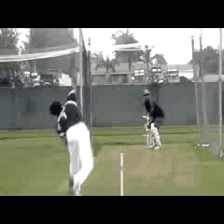

In [ ]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Ścieżka testowego pliku video: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

Jak widać po otrzymanym wyniku, wskaane klasy nie posiadają dużych wartości, ale są dosyć poprawne. Należy brać pod uwagę fakt,że model był trenowany na sotsunkow niwielkiej liczbie przykładów.

Zachęcam do eksperymentowania z notatnikiem, prób zwiększania liczby warstw i liczby neuronów.

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>